In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pencil as pc
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid as trap
from astropy.convolution import convolve, Box1DKernel
import modes
from IPython.display import display, Latex

         pencil has moved to pencil_old.
To change your scripts accordingly:
import pencilnew as pc -> import pencil as pc
import pencil as pc -> import pencil_old as pc


In [2]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['text.usetex'] = True

In [3]:
sim = pc.get_sim(quiet=True)
ts = pc.read.ts()
yaver = pc.read.aver(plane_list='y')
xyaver = pc.read.aver(plane_list=['xy'])

Read 16076 lines.


In [4]:
class Phase(modes.Modes):
    """
    To analyze different phases
    """

    def __init__(self, path, t1, t2, z_ref, norm, sim, ts, xyaver, yaver, ini=False, dyn=True):
        super().__init__(sim, ts, xyaver, yaver, ini=False, dyn=True)

        self.path = path
        self.t = self.yaver.t
        self.z_ref = z_ref
        self.norm = norm

        self.kf = super().get_kf()
        self.indx_t1 = np.argmin(np.abs(self.yaver.t-t1))
        self.indx_t2 = np.argmin(np.abs(self.yaver.t-t2))

        self.uz_real = self.yaver.y.uzmxz[self.indx_t1:self.indx_t2,:,self.z_ref]
        self.uz_fourier = super().FT(self.uz_real, self.norm)
        # self.uz_fourier = super().FT(self.uz_real, 'ortho')
        self.log_P = super().logP(self.uz_fourier, self.d)
        self.om_til = super().omega_tilde(self.indx_t1, self.indx_t2)
        self.k_til = super().k_tilde()
        self.upto_indx = super().upto(self.indx_t1, self.indx_t2)

    def indx_k(self, k_xtil:np.ndarray):
        indx = np.argmin(np.abs(self.k_til-k_xtil))
        return indx
    
    def Power(self, indx:int):
        P = np.exp(self.log_P[:self.upto_indx,indx])
        return P
    
    def Power_filtered(self, power:np.ndarray, sigma):
        P_filt = gaussian_filter(power[:self.upto_indx],sigma)
        return P_filt
    
    def f_freq(self, k_tilx):
        # freq = round(self.fmodes(k_tilx),3)
        freq = self.fmodes(k_tilx)
        return freq
    
    def p_freq(self, k_tilx, num):
        if isinstance(num, int):
            freq = round(self.pmodes(k_tilx,num),3)
        if isinstance(num, list):
            freq=[]
            for i in range(len(num)):
                freq.append(self.pmodes(k_tilx,i))
        return freq
    
    def plot(self, ax, P:np.ndarray, **kwargs):
        ax.plot(self.om_til[:self.upto_indx], P, **kwargs)
        # ax.grid()
        # ax.set_ylim(0,)
        ax.legend()

    def xlim(self, x_data:np.ndarray):
        min = x_data[0]
        max = x_data[-1]
        return (min,max)
    
    def cs_du(self, k_tilx):
        csd = self.cs_d*k_tilx/(self.L0*self.omega0)
        csu = self.cs_u*k_tilx/(self.L0*self.omega0)
        return (csd, csu)
    
    def mode_mass(self, x_data, y_data, u_d, **kwargs):
        """
        Calculate mode mass by integrating
        y_data in the interval x_data
        x_data: \omega_tilde range for a mode
        y_data: corresponding P(\omega_tilde)
        u_d: rms velocity in lower layer
        """
        # if kinematic == True:
        #     u_d = 0.1244
        # elif saturated == True:
        #     u_d = 0.0988
        # else:
        #     u_d = 1     #NOTE: not normalized
        norm = u_d/(3*self.kf)
        mass = trap(y_data, x=x_data)
        norm_mass = mass/norm
        return np.round(norm_mass, 4)

    def shift(self, f_om_calc, f_om):
        """
        Calculate relative freq shift from
        calculated \omega_f and theoretical
        \omega_f
        """
        return np.round((f_om_calc**2-f_om**2)/f_om**2, 4)

    def indx_fwhm(self, P_om, om_f, peak_f):
        """
        P_om: fitted spectrum (i.e., P(\omega)
        of P(\omega) vs \omega )
        om_f: freq range around \omega_f
        peak_f: freq of f mode calculated
        from fitting
        """
        indx_peak = np.argmin(np.abs(om_f-peak_f))
        peak = P_om[indx_peak]
        lh = np.argmin(np.abs(P_om[:indx_peak]-peak/2))
        uh = indx_peak + np.argmin(np.abs(P_om[indx_peak+1:]-peak/2))
        return [lh, uh]
    
    def line_width(self, om_f, indx_fwhm, f_om):
        return np.round((om_f[int(indx_fwhm[1])] - om_f[int(indx_fwhm[0])])/f_om, 4)

    def mode_fit_para(self, func, x_data, y_data, **kwargs):
        para, _ = curve_fit(func, x_data, y_data, **kwargs)
        return para
    
    def mode_fit_extend(self, func, x, para):
        y = func(x, *para)-x*para[4]-para[3]
        return y

    pass

In [5]:
path = './plots/'

In [6]:
kinematic = Phase(path, 200, 1500, 212, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)
saturated = Phase(path, 2300, 4200, 212, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)

Have you included bx2mz and by2mz in xyaver.in?
Have you included bx2mz and by2mz in xyaver.in?


In [7]:
indx_kin = []
indx_sat = []

for i in [2,3,4,5]:
    indx_kin.append(kinematic.indx_k(i))
    indx_sat.append(saturated.indx_k(i))

In [8]:
P_kin = kinematic.Power(indx_kin).T
P_sat = saturated.Power(indx_sat).T

In [9]:
label_kin = []
P_kin_filt = np.empty(np.shape(P_kin))
# P_sat_filt = np.empty(np.shape(P_sat))
for i, indx in enumerate(indx_kin):
    P_kin_filt[i,:] =convolve(P_kin[i,:], Box1DKernel(5))
    label_kin.append(kinematic.k_til[:kinematic.upto_indx][indx])
    # P_sat_filt[i,:] =convolve(P_sat[i,:], Box1DKernel(5))

In [10]:
label_kin

[1.9634954084936207, 3.141592653589793, 3.9269908169872414, 5.105088062083414]

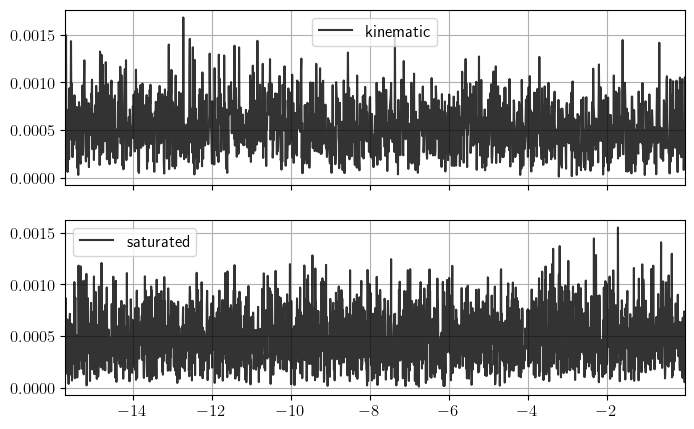

In [11]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))#sharex=True,

kinematic.plot(axs[0], P_kin[2], label='kinematic', c='k', alpha=0.8)
# kinematic.plot(axs[0], P_kin_filt[3], label='filtered')
saturated.plot(axs[1], P_sat[2], label='saturated', c='k', alpha=0.8)
# saturated.plot(axs[1], P_sat_filt[3], label='filtered')

# axs[1].set_xlim(0,kinematic.om_til[kinematic.upto_indx-1])
axs[1].set_xlim(kinematic.xlim(kinematic.om_til[:kinematic.upto_indx-1]))
# axs[1].set_ylim(0,1.75)
axs[0].grid()
axs[1].grid()

### $\omega$ of f-modes at the corresponding $k_x$

In [12]:
f_om = kinematic.f_freq(kinematic.k_til[indx_kin])
# f_om

In [13]:
how_many = 4

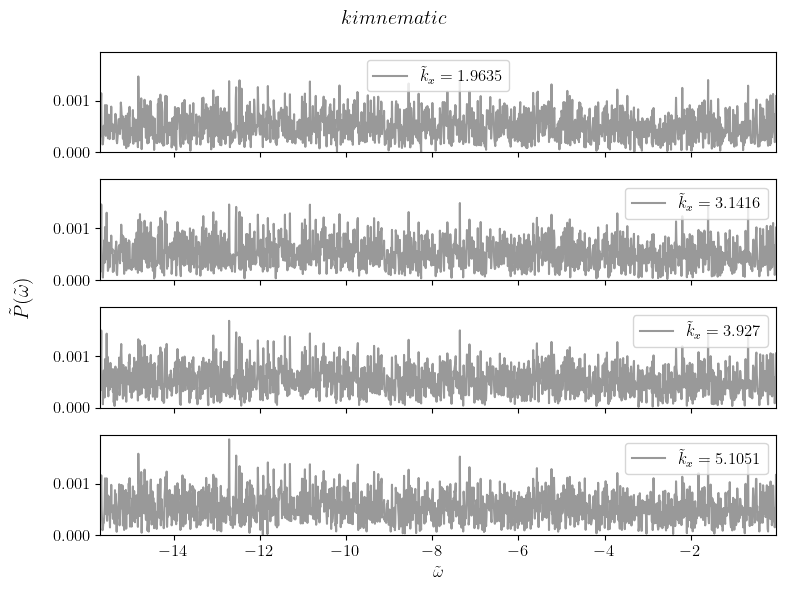

In [14]:
hm = how_many
fig, axs = plt.subplots(4,1, sharex=True, sharey=True, figsize=(8,6))#sharex=True,

for i in range(4):
    kinematic.plot(axs[i], P_kin[i], c='k', alpha=0.4, label=fr'$\tilde{{k}}_x={round(label_kin[i],4)}$')
    axs[i].axvline(x=f_om[i], ls=':', c='b')

axs[1].set_xlim(kinematic.xlim(kinematic.om_til[:kinematic.upto_indx-1]))
axs[0].set_ylim(0,)
axs[0].legend()

plt.xlabel(r"$\tilde{\omega}$")
fig.supylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(r"$kimnematic$")
#plt.yscale('log')
plt.tight_layout()
plt.show()

In [15]:
# fig, axs = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,5))#sharex=True,

# for i in range(3):
#     saturated.plot(axs[i], P_kin[i], c='k', alpha=0.4, label=fr'$\tilde{{k}}_x={round(label_sat[i],3)}$')
#     axs[i].axvline(x=f_om[i], ls=':', c='b')

# axs[1].set_xlim(saturated.xlim(saturated.om_til[:saturated.upto_indx-1]))
# axs[0].set_ylim(0,)
# axs[0].legend()

# plt.xlabel(r"$\tilde{\omega}$")
# fig.supylabel(r"$\tilde{P}(\tilde{\omega})$")
# plt.suptitle(r"$kimnematic$")
# #plt.yscale('log')
# plt.tight_layout()
# plt.show()

In [16]:
om_kin = kinematic.om_til[:kinematic.upto_indx]
# indx_f = np.argmin(np.abs(om_kin-f_om))
idl_f_kin = []
idu_f_kin = []
P_f_kin = []
om_f_kin = []

d = [1.12, 1.5, 1.7, 2.0]
u = [2.10, 2.2, 2.5, 2.6]

for i in range(hm):
    idl_f_kin.append(np.argmin(np.abs(om_kin - d[i])))
    idu_f_kin.append(np.argmin(np.abs(om_kin - u[i])))

    # P_f_kin.append(P_kin[i, idl_f_kin[i]:idu_f_kin[i]])
    P_f_kin.append(P_kin_filt[i, idl_f_kin[i]:idu_f_kin[i]])
    om_f_kin.append(om_kin[idl_f_kin[i]:idu_f_kin[i]])

IndexError: index 0 is out of bounds for axis 0 with size 0

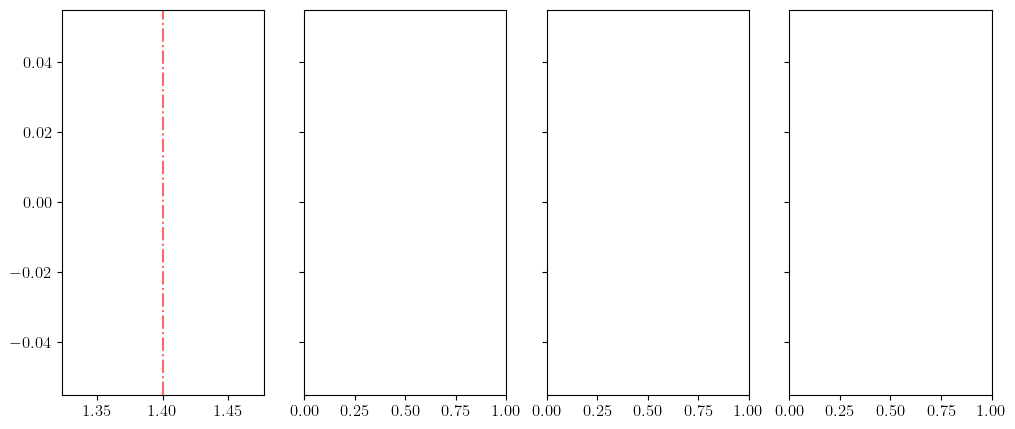

In [17]:
fig, axs = plt.subplots(1,hm, sharey=True, figsize=(12,5))#sharex=True,

for i in range(hm):
    axs[i].plot(om_f_kin[i], P_f_kin[i], c='k', ls=':', label=fr'$\tilde{{k}}_x={round(label_kin[i],3)}$')
    axs[i].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
    # axs[i].axvline(x=f_om[i], ls=':', c='b')
    axs[i].set_xlim(om_f_kin[i][i], om_f_kin[i][-1])
    axs[i].legend()

axs[0].set_ylim(0,)

plt.xlabel(r"$\tilde{\omega}$")
fig.supylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(r"$kimnematic$")
#plt.yscale('log')
plt.tight_layout()
plt.show()



### fitting function

In [ ]:
def lorentzian(x, a, b, c, d, e):
    y = a/((x-b)**2+np.exp(c))+d+e*x
    return y

In [ ]:
para_f_kin = np.zeros((hm,5))

a_kin = [0.6, 0.4, 0.4, 0.8]
b_kin = [1.6, 1.7, 2.1, 2.3]
d_kin = [-7.7, -1.0, -1.0, -1.0]
e_kin = [0.4, 0.1, 0.1, 0.1]

a_sat = [0.6, 0.4, 0.4, 0.8]
b_sat = [1.0, 1.5, 2.2, 2.3]
d_sat = [-7.7, -1.0, -1.0, -1.0]
e_sat = [0.4, 0.1, 0.1, 0.1]


x_kin = np.zeros((hm,2000))
y_kin = np.zeros((hm,2000))

for i in range(hm):
    para_f_kin[i,:] = kinematic.mode_fit_para(lorentzian, om_f_kin[i], P_f_kin[i], p0 = np.array([a_kin[i],b_kin[i],-2,d_kin[i],e_kin[i]]))
    x_kin[i] = np.linspace(para_f_kin[i,1]-1.0, para_f_kin[i,1]+1.0, 2000)
    y_kin[i] = kinematic.mode_fit_extend(lorentzian, x_kin[i], para_f_kin[i,:])


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

In [ ]:
np.shape(x_kin)

: 

In [ ]:
fig, axes = plt.subplots(1,hm, sharey=True, figsize=(12,5))
for i in range(hm):
    axes[i].plot(om_f_kin[i], P_f_kin[i], color='k', ls=":", alpha=0.6)#, label=r'$kinematic$ $phase$')
    axes[i].plot(x_kin[i], y_kin[1], ls=':', color='k', label=fr'$\tilde{{k}}_x={round(label_kin[i],3)}$')#fitted_f_kin_lor-para_f_kin_lor[3],
    # axes[i].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
    axes[i].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))
    axes[i].set_xlabel(r"$\tilde{\omega}$")

# axes[1].set_xlabel(r"$\tilde{\omega}$")
axes[0].set_ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(r"$kinematic$")
plt.tight_layout()
plt.show()

: 

In [ ]:
fig, ax = plt.subplots(1,hm, sharey=True, figsize=(12,5))
for i in range(hm):
    ax[i].plot(x_kin[i], y_kin[i], ls=':', color='k', label=fr'$\tilde{{k}}_x={round(label_kin[i],3)}$')#fitted_f_kin_lor-para_f_kin_lor[3],
    ax[i].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
    ax[i].axvline(x=para_f_kin[i][1], ls='--', c='g')
    ax[i].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))
    ax[i].set_xlim(x_kin[i][i], x_kin[i][-1])
    # ax[i].set_ylim(0,)
    ax[i].set_xlabel(r"$\tilde{\omega}$")

# ax[1].set_xlabel(r"$\tilde{\omega}$")
ax[0].set_ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(r"$kinematic$")
plt.tight_layout()
plt.show()

: 

In [ ]:
para_f_kin[0]

: 

### Characteristics

In [ ]:
def ave(*args):
    list = [*args]
    arr = np.array(list)
    return round(np.sum(arr)/len(list),4)

: 

In [ ]:
# var6 = pc.read.var('VAR6')
# var12 = pc.read.var('VAR12')
# var18 = pc.read.var('VAR18')
# u_d_kin = ave(kinematic.u_rms_d(var6), kinematic.u_rms_d(var12), kinematic.u_rms_d(var18))

: 

In [ ]:
u_d_kin = 0.1246    #NOTE: the value is calculated by above method

: 

In [ ]:
mode_mass_kin = np.zeros(hm)
shift_kin = np.zeros(hm)
indx_fwhm_kin = np.zeros((hm,2))
ln_wd_kin = np.zeros(hm)

for i in range(hm):
    mode_mass_kin[i] = kinematic.mode_mass(x_kin[i], y_kin[i], u_d_kin)#; mode_mass_sat = mode_mass(f_sat[0], f_sat[1], u_d_sat)
    shift_kin[i] = kinematic.shift(para_f_kin[i,1], f_om[i])
    indx_fwhm_kin[i,:] = kinematic.indx_fwhm(y_kin[i], x_kin[i], para_f_kin[i,1])
    ln_wd_kin[i] = kinematic.line_width(x_kin[i,:], indx_fwhm_kin[i,:], f_om[i])



: 

In [ ]:
para_f_kin[2,1]

: 

In [ ]:
indx_fwhm_kin

: 

In [ ]:
np.shape(x_kin)

: 

In [ ]:
mode_mass_kin

: 

In [ ]:
shift_kin

: 

In [ ]:
ln_wd_kin

: 

In [ ]:
def st_line(x,a,b):
    return a*x+b

para_st_kin, _ = curve_fit(st_line, label_kin, shift_kin)

x = np.linspace(label_kin[0], label_kin[-1], 100)
y = st_line(x, *para_st_kin)

: 

In [ ]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(6,5))
size = 10
ax[0].scatter(label_kin, mode_mass_kin, color='k', s=size)#fitted_f_kin_lor-para_f_kin_lor[3],
ax[1].scatter(label_kin, shift_kin, color='k', s=size)#fitted_f_kin_lor-para_f_kin_lor[3],
ax[2].scatter(label_kin, ln_wd_kin, color='k', s=size)#fitted_f_kin_lor-para_f_kin_lor[3],

ax[1].plot(x, y, c='r', ls=':')

ax[0].set_ylim(np.min(mode_mass_kin)-0.5, np.max(mode_mass_kin)+0.5)
ax[1].set_ylim(np.min(shift_kin)-0.02, np.max(shift_kin)+0.01)
ax[2].set_ylim(np.min(ln_wd_kin)-0.03, np.max(ln_wd_kin)+0.03)

ax[0].set_ylabel(r'$\mu_{f,kin}$')
ax[1].set_ylabel(r'$\delta\omega_{f,kin}^2/\omega_f^2$')
ax[2].set_ylabel(r'$\Gamma_{f,kin}$')
plt.xlabel(r'$\tilde{k}_x$')
plt.savefig('./plots/modes.png', dpi=300)
plt.show()

: 

In [ ]:
indx_fwhm_kin[0,1]

: 

In [ ]:
x_kin[0,1108]

: 

In [ ]:
(1.6798-1.4617)/f_om[0]

: 

In [ ]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4.55))
# [indx]
## ax.plot(f_kin[0], f_kin[1], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
## ax.scatter(f_kin[0][indx_fwhm_kin], f_kin[1][indx_fwhm_kin])

ax.plot(x_kin[0], y_kin[0], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
ax.scatter([1.4617, 1.6798], [0.1278, 0.129])

: 

In [ ]:
f_om[1]

: 

In [ ]:
para_f_kin[2][1]

: 

In [ ]:
indx_fwhm_kin[2,:][0]

: 

In [ ]:
x_kin[1]

: 

: 